In [11]:
import os

import imageio
import numpy as np
import pandas as pd
import skimage
from skimage import color, io
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

def get_image_list(root_path):
    image_list = []
    for root, dirs, files in os.walk(root_path):
        for filename in files:
            if filename.endswith(('.jpeg', '.jpg')):
                image_list.append(os.path.join(root, filename))
    return image_list


def get_lake_color_characteristics(lakecam_images_path):
    # Get lists of image file paths
    lakecam_image_list = get_image_list(lakecam_images_path)

    # Load the set of images taken from the lake camera
    lake_images = [io.imread(image_path) for image_path in lakecam_image_list]

    # Calculate the mean and standard deviation of each channel in LAB color space for the lake images
    lake_mean = np.mean([color.rgb2lab(img).mean(axis=(0, 1)) for img in lake_images], axis=0)
    lake_std = np.mean([color.rgb2lab(img).std(axis=(0, 1)) for img in lake_images], axis=0)

    # Create a pandas DataFrame with the lake mean and standard deviation
    df = pd.DataFrame({'lake_mean': lake_mean, 'lake_std': lake_std})

    # Get the current working directory and concatenate the Excel file name to it
    current_directory = os.getcwd()
    excel_file_path = os.path.join(current_directory, 'lake_color_characteristics.xlsx')

    # Write the DataFrame to an Excel file with headers
    # df.to_excel(excel_file_path, index=False, header=['lake_mean', 'lake_std'], mode='w')
    df.to_excel(excel_file_path, index=False, header=['lake_mean', 'lake_std'])

    return lake_mean, lake_std


def load_lake_color_characteristics(excel_file_name):
    # Get the Excel file path
    current_directory = os.getcwd()
    excel_file_path = os.path.join(current_directory, excel_file_name)

    # Load the Excel file as a pandas DataFrame, or return None if it doesn't exist
    if not os.path.exists(excel_file_path):
        print(f"Excel file '{excel_file_name}' doesn't exist in the current directory.")
        return None
    df = pd.read_excel(excel_file_path)

    # Extract the lake mean and standard deviation from the DataFrame
    lake_mean = df['lake_mean'].values
    lake_std = df['lake_std'].values

    return lake_mean, lake_std


def color_transfer_on_image(labcam_image_path, lake_mean, lake_std):
    lab_image = io.imread(labcam_image_path)
    # Calculate the mean and standard deviation of each channel in LAB color space for the input lab image
    lab_mean = color.rgb2lab(lab_image).mean(axis=(0, 1))
    lab_std = color.rgb2lab(lab_image).std(axis=(0, 1))

    # Compute the color transform from the lab image to the lake image
    a = (lake_std / lab_std) * (color.rgb2lab(lab_image) - lab_mean) + lake_mean
    img_transfer = color.lab2rgb(a)

    return img_transfer


def color_transfer_on_single_image(labcam_image_path, lake_mean, lake_std):
    # Load the LAB image
    lab_image = io.imread(labcam_image_path)

    # Calculate the mean and standard deviation of each channel in LAB color space for the input lab image
    lab_mean = color.rgb2lab(lab_image).mean(axis=(0, 1))
    lab_std = color.rgb2lab(lab_image).std(axis=(0, 1))

    # Compute the color transform from the lab image to the lake image
    a = (lake_std / lab_std) * (color.rgb2lab(lab_image) - lab_mean) + lake_mean
    img_transfer = color.lab2rgb(a)

    return img_transfer


def color_transfer_on_image_list(labcam_images_path, lake_mean, lake_std, output_directory):
    # Get lists of image file paths
    labcam_image_list = get_image_list(labcam_images_path)

    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    # Iterate over all the LAB images in the input directory
    for lab_image_path in labcam_image_list:
        # Load the LAB image
        lab_image = io.imread(lab_image_path)

        # Calculate the mean and standard deviation of each channel in LAB color space for the input lab image
        lab_mean = color.rgb2lab(lab_image).mean(axis=(0, 1))
        lab_std = color.rgb2lab(lab_image).std(axis=(0, 1))

        # Compute the color transform from the lab image to the lake image
        a = (lake_std / lab_std) * (color.rgb2lab(lab_image) - lab_mean) + lake_mean
        img_transfer = color.lab2rgb(a)

        # Get the file name from the lab_image_path
        filename = os.path.basename(lab_image_path)

        # Save the result as a JPEG image in the output directory
        output_path = os.path.join(output_directory, filename)
        os.makedirs(output_directory, exist_ok=True)

        # Convert the image to uint8
        img_uint8 = skimage.img_as_ubyte(img_transfer)

        # Save the uint8 image
        imageio.imwrite(output_path, img_uint8)

        # io.imsave(output_path, img_transfer, quality=95)

    return


In [12]:

lakecam_images_path = 'RGB color correction/lakecam/'
labcam_images_path = 'RGB color correction/labcam/'

# Get lists of image file paths
labcam_image_list = get_image_list(labcam_images_path)
lakecam_image_list = get_image_list(lakecam_images_path)


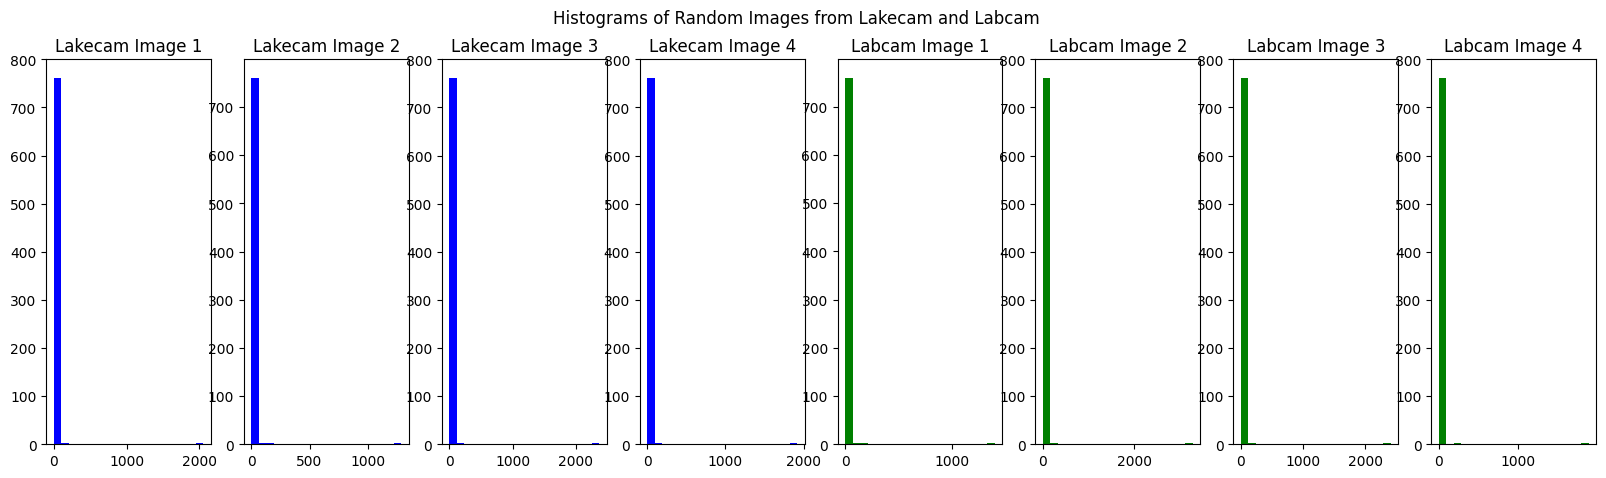

In [13]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Set up figure with 2x4 subplots
fig, axs = plt.subplots(1, 8, figsize=(20,5))

# Select 4 random images from each list
lakecam_images = random.sample(lakecam_image_list, 4)
labcam_images = random.sample(labcam_image_list, 4)

# Plot histograms for lakecam images
for i in range(4):
    img = Image.open(lakecam_images[i])
    axs[i].hist(img.histogram(), bins=20, color='blue')
    axs[i].set_title(f"Lakecam Image {i+1}")

# Plot histograms for labcam images
for i in range(4):
    img = Image.open(labcam_images[i])
    axs[i+4].hist(img.histogram(), bins=20, color='green')
    axs[i+4].set_title(f"Labcam Image {i+1}")

# Set overall title for the figure
fig.suptitle("Histograms of Random Images from Lakecam and Labcam")

# Display the figure
plt.show()


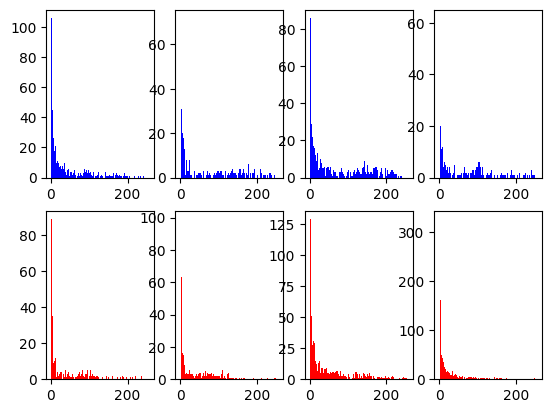

In [15]:
# Read in the images, convert to grayscale, and ignore black pixels
lakecam_images = []
labcam_images = []
for i in range(4):
    lakecam_image = cv2.imread(lakecam_image_list[i], cv2.IMREAD_GRAYSCALE)
    lakecam_image = lakecam_image[lakecam_image > 0] # ignore black pixels
    lakecam_images.append(lakecam_image)
    
    labcam_image = cv2.imread(labcam_image_list[i], cv2.IMREAD_GRAYSCALE)
    labcam_image = labcam_image[labcam_image > 0] # ignore black pixels
    labcam_images.append(labcam_image)

# Calculate the histogram for each image
lakecam_histograms = []
labcam_histograms = []
for image in lakecam_images:
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    lakecam_histograms.append(histogram)
    
for image in labcam_images:
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    labcam_histograms.append(histogram)

# Plot the histograms
fig, axs = plt.subplots(2, 4)
for i in range(4):
    axs[0, i].hist(lakecam_images[i], bins=256, range=(0, 256), color='blue')
    axs[1, i].hist(labcam_images[i], bins=256, range=(0, 256), color='red')
plt.show()

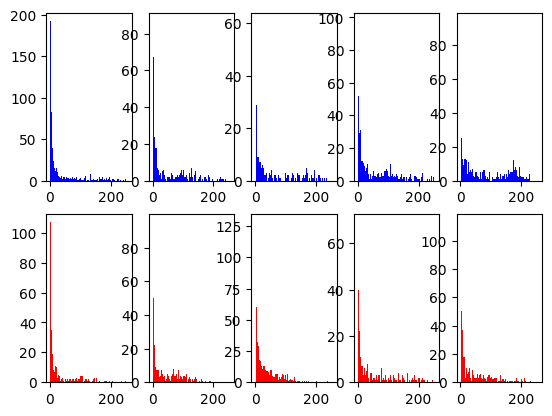

In [27]:
# Read in the images, convert to grayscale, and ignore black pixels
lakecam_images = []
labcam_images = []
for i in range(5):
    lakecam_image_path = random.choice(lakecam_image_list)
    lakecam_image = cv2.imread(lakecam_image_path, cv2.IMREAD_GRAYSCALE)
    lakecam_image = lakecam_image[lakecam_image > 0] # ignore black pixels
    lakecam_images.append(lakecam_image)
    
    labcam_image_path = random.choice(labcam_image_list)
    labcam_image = cv2.imread(labcam_image_path, cv2.IMREAD_GRAYSCALE)
    labcam_image = labcam_image[labcam_image > 0] # ignore black pixels
    labcam_images.append(labcam_image)

# Calculate the histogram for each image
lakecam_histograms = []
labcam_histograms = []
for image in lakecam_images:
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    lakecam_histograms.append(histogram)
    
for image in labcam_images:
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    labcam_histograms.append(histogram)

# Plot the histograms
fig, axs = plt.subplots(2, 5)
for i in range(5):
    axs[0, i].hist(lakecam_images[i], bins=256, range=(0, 256), color='blue')
    axs[1, i].hist(labcam_images[i], bins=256, range=(0, 256), color='red')
plt.show()

IndexError: index 7 is out of bounds for axis 0 with size 7

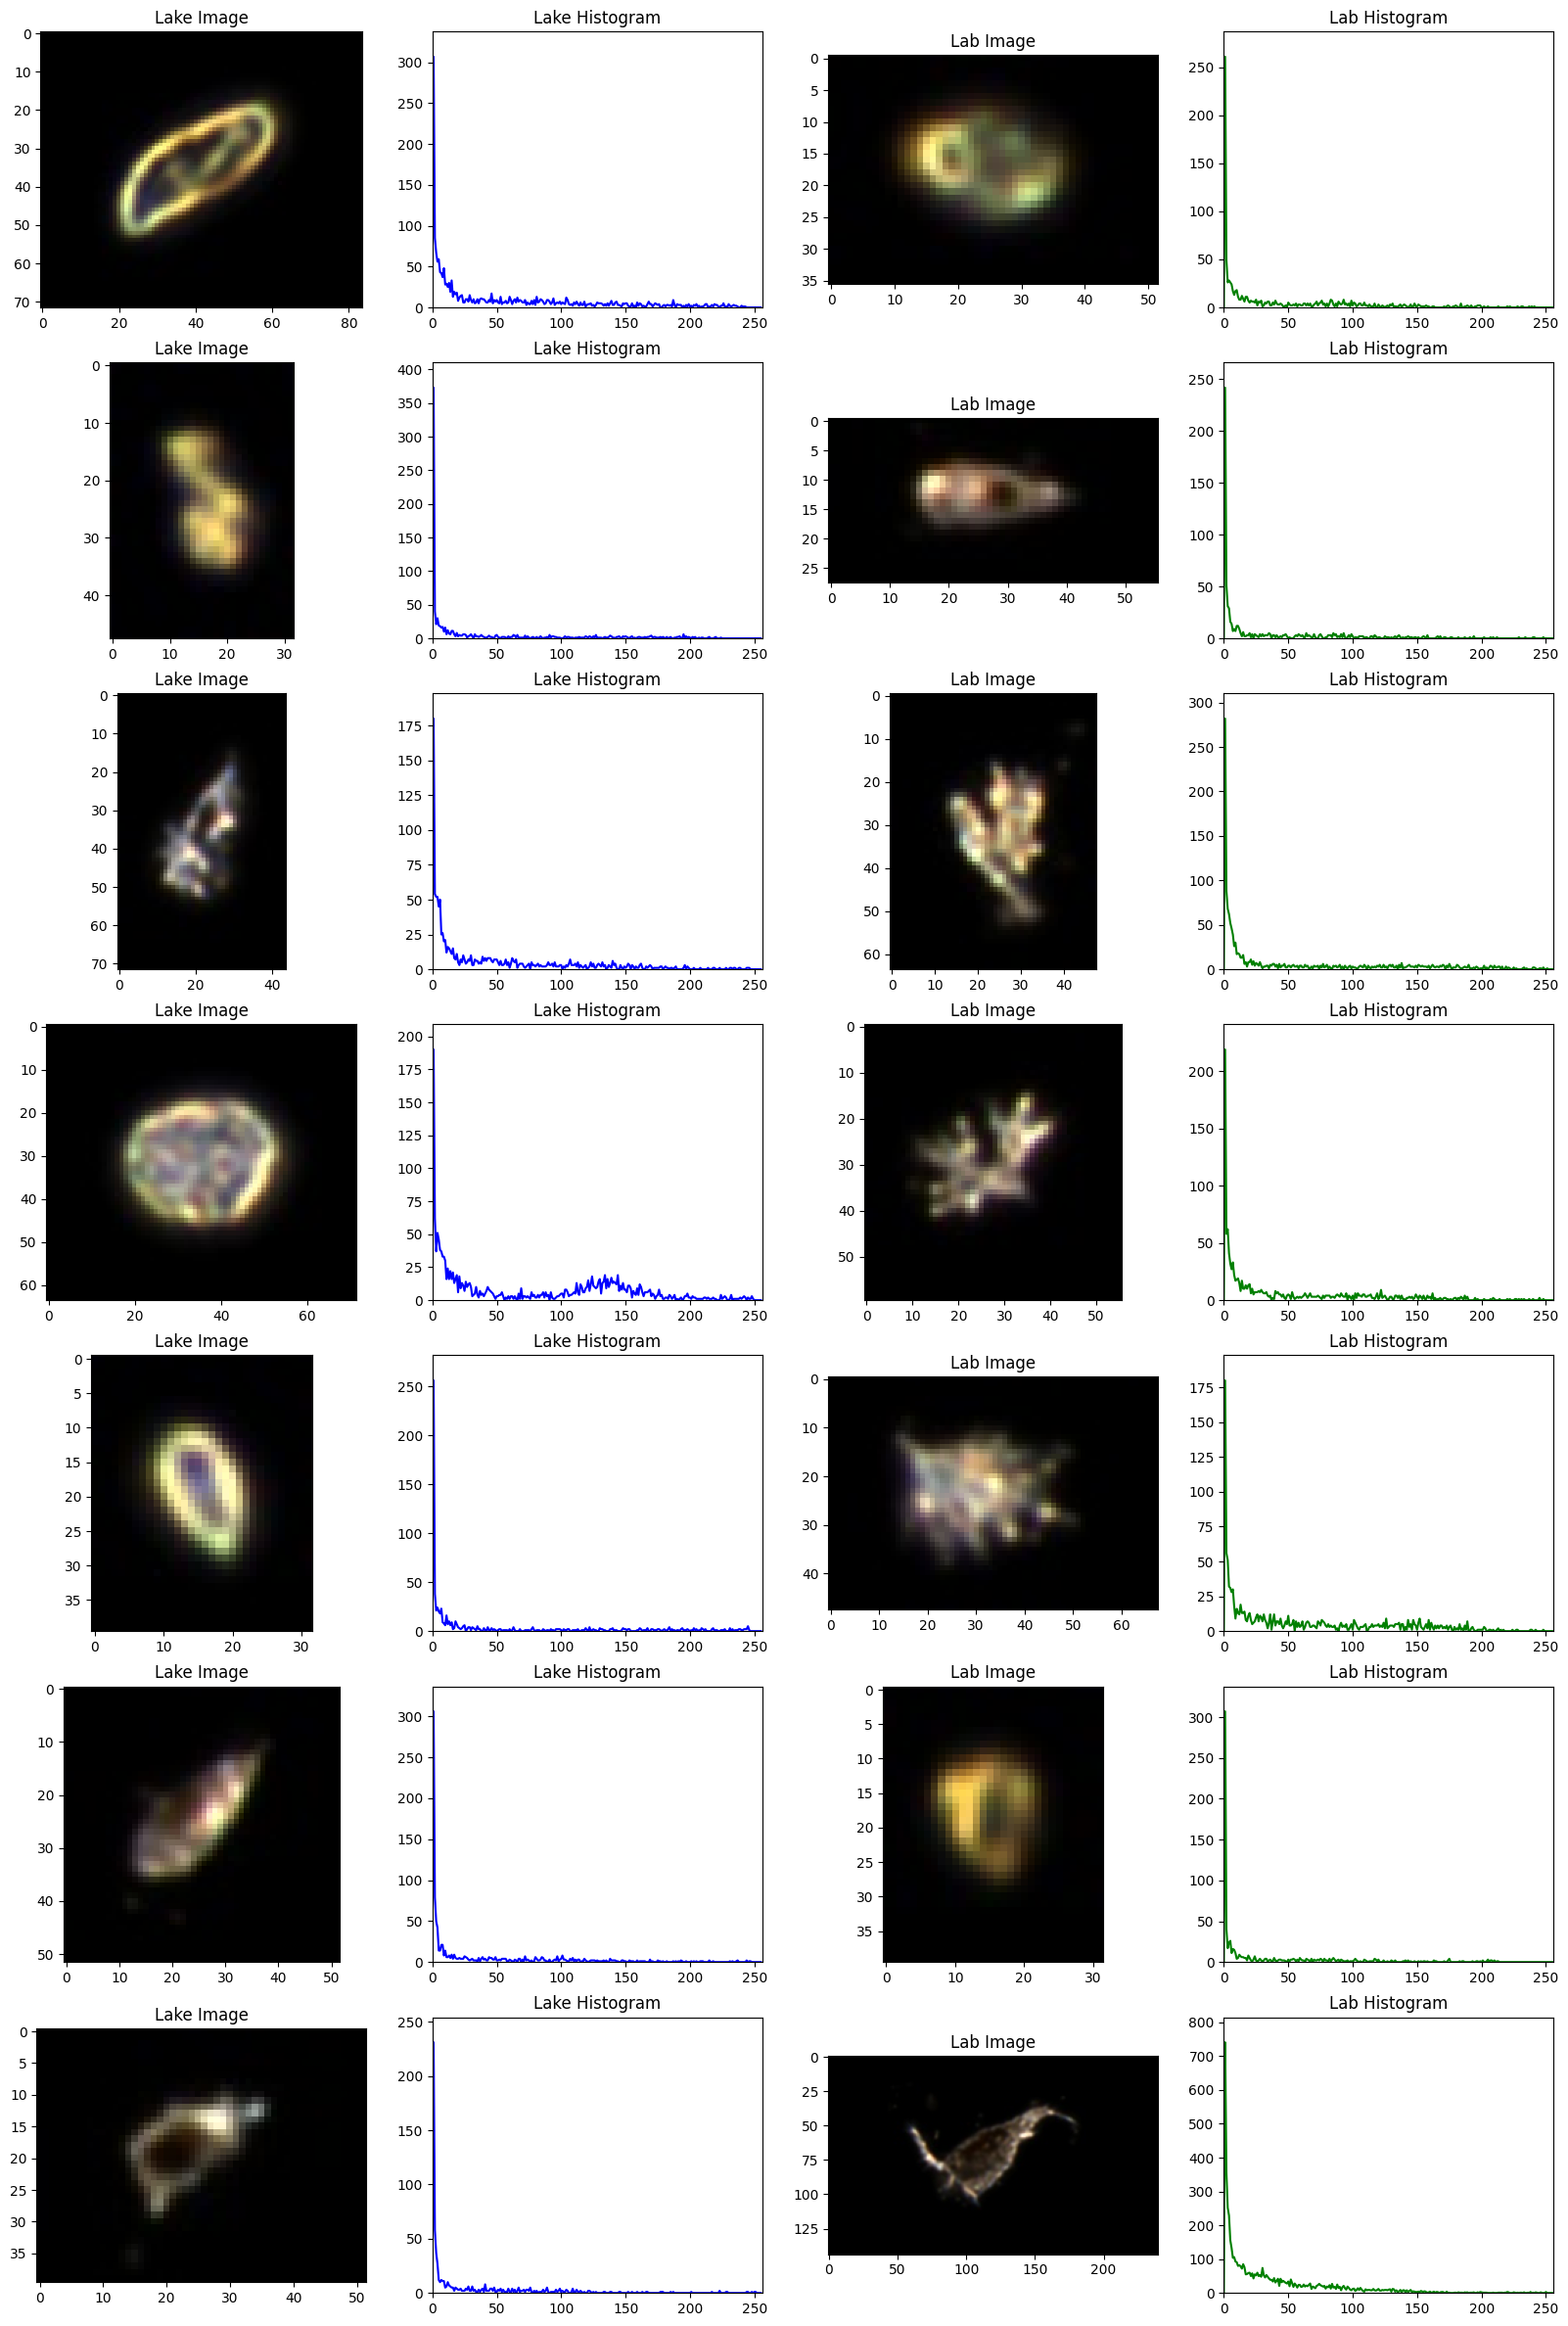

In [49]:
import random

# Get lists of image file paths
lakecam_images_path = 'RGB color correction/lakecam/'
labcam_images_path = 'RGB color correction/labcam/'
labcam_image_list = get_image_list(labcam_images_path)
lakecam_image_list = get_image_list(lakecam_images_path)

# Randomly select 7 images from each list
random_lakecam_image_list = random.sample(lakecam_image_list, 7)
random_labcam_image_list = random.sample(labcam_image_list, 7)

# Create a figure with 14 subplots
fig, axs = plt.subplots(nrows=7, ncols=4, figsize=(20, 30))

# Plot the images and histograms
for i in range(7):
    # Plot the lake image and histogram on the top row
    lakecam_image_path = random_lakecam_image_list[i]
    img = cv2.imread(lakecam_image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist[0] = 0
    axs[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i, 0].set_title('Lake Image')
    axs[i, 1].plot(hist, color='blue')
    axs[i, 1].set_xlim([0, 256])
    axs[i, 1].set_ylim([0, np.max(hist) * 1.1])
    axs[i, 1].set_title('Lake Histogram')

    # Plot the lab image and histogram on the bottom row
    labcam_image_path = random_labcam_image_list[i]
    img = cv2.imread(labcam_image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist[0] = 0
    axs[i, 2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i, 2].set_title('Lab Image')
    axs[i, 3].plot(hist, color='green')
    axs[i, 3].set_xlim([0, 256])
    axs[i, 3].set_ylim([0, np.max(hist) * 1.1])
    axs[i, 3].set_title('Lab Histogram')

# Remove unused subplots
for i in range(7, 14):
    for j in range(4):
        axs[i, j].axis('off')

# Show the figure
plt.show()

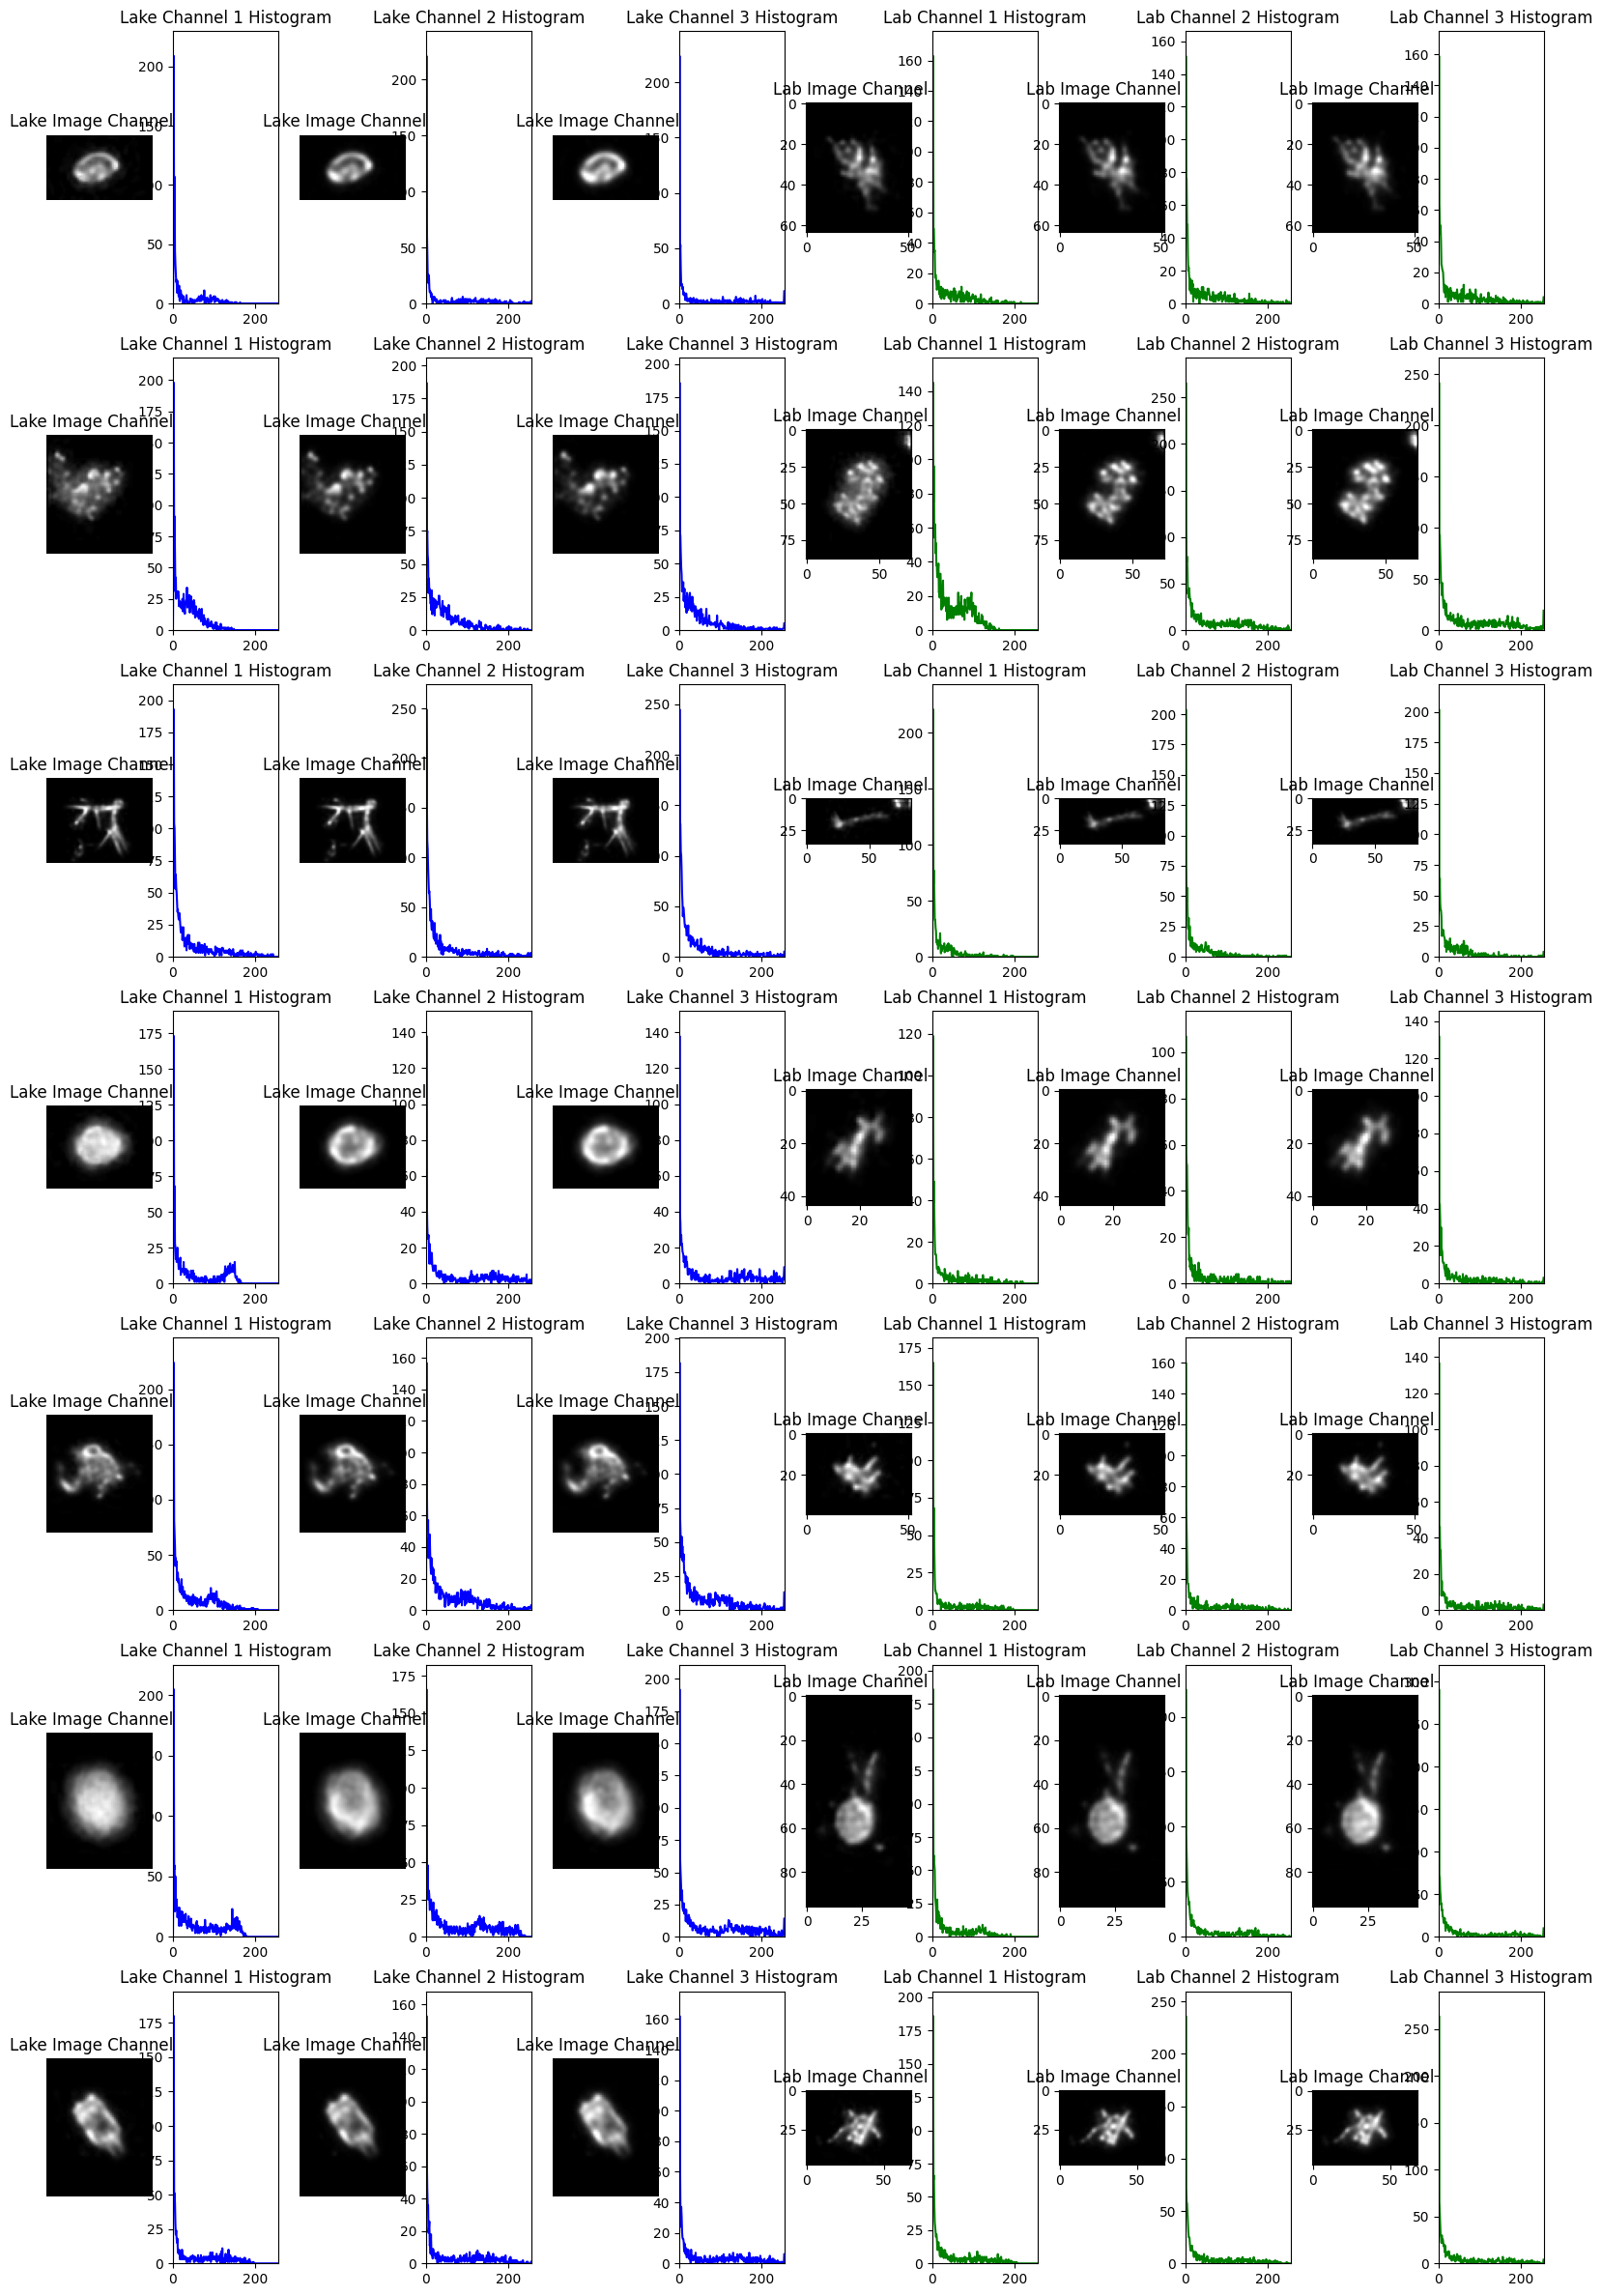

In [53]:
import random

# Get lists of image file paths
lakecam_images_path = 'RGB color correction/lakecam/'
labcam_images_path = 'RGB color correction/labcam/'
labcam_image_list = get_image_list(labcam_images_path)
lakecam_image_list = get_image_list(lakecam_images_path)

# Randomly select 7 images from each list
random_lakecam_image_list = random.sample(lakecam_image_list, 7)
random_labcam_image_list = random.sample(labcam_image_list, 7)

# Create a figure with 21 subplots
fig, axs = plt.subplots(nrows=7, ncols=12, figsize=(20, 30))

# Plot the images and histograms
for i in range(7):
    # Plot the lake image and histogram on the top row for each channel
    lakecam_image_path = random_lakecam_image_list[i]
    img = cv2.imread(lakecam_image_path)
    for j in range(3):
        channel = cv2.split(img)[j]
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
        hist[0] = 0
        axs[i, j*2].imshow(channel, cmap='gray')
        axs[i, j*2].set_title(f"Lake Image Channel {j+1}")
        axs[i, j*2+1].plot(hist, color='blue')
        axs[i, j*2+1].set_xlim([0, 256])
        axs[i, j*2+1].set_ylim([0, np.max(hist) * 1.1])
        axs[i, j*2+1].set_title(f"Lake Channel {j+1} Histogram")

    # Plot the lab image and histogram on the bottom row for each channel
    labcam_image_path = random_labcam_image_list[i]
    img = cv2.imread(labcam_image_path)
    for j in range(3):
        channel = cv2.split(img)[j]
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
        hist[0] = 0
        axs[i, (j+3)*2].imshow(channel, cmap='gray')
        axs[i, (j+3)*2].set_title(f"Lab Image Channel {j+1}")
        axs[i, (j+3)*2+1].plot(hist, color='green')
        axs[i, (j+3)*2+1].set_xlim([0, 256])
        axs[i, (j+3)*2+1].set_ylim([0, np.max(hist) * 1.1])
        axs[i, (j+3)*2+1].set_title(f"Lab Channel {j+1} Histogram")

# Remove unused subplots
for i in range(7):
    for j in range(6):
        if j not in [1, 3, 5]:
            axs[i, j].axis('off')

# Show the figure
plt.show()

In [ ]:
# import random

# def plot_image_and_histogram(image_path, ax1, ax2):
#     # Load the image and convert it to grayscale
#     img = cv2.imread(image_path)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     # Calculate the histogram
#     hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

#     # Ignore black pixels in the histogram
#     hist[0] = 0

#     # Plot the image in the first subplot
#     ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     ax1.set_title('Image')

#     # Plot the histogram in the second subplot
#     ax2.plot(hist, color='gray')
#     ax2.set_xlim([0, 256])
#     ax2.set_ylim([0, np.max(hist) * 1.1])
#     ax2.set_title('Histogram')

# # Get lists of image file paths
# lakecam_images_path = 'RGB color correction/lakecam/'
# labcam_images_path = 'RGB color correction/labcam/'
# labcam_image_list = get_image_list(labcam_images_path)
# lakecam_image_list = get_image_list(lakecam_images_path)

# # Create a figure with four subplots
# fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

# # Plot the images and histograms
# for i in range(2):
#     # Select random images from the lists
#     lakecam_image_path = random.choice(lakecam_image_list)
#     labcam_image_path = random.choice(labcam_image_list)

#     print(f"Image {i+1} from lakecam: {lakecam_image_path}")
#     # Plot the lake image and histogram on the top row
#     plot_image_and_histogram(lakecam_image_path, axs[0, i*2], axs[0, i*2+1])

#     print(f"Image {i+1} from labcam: {labcam_image_path}")
#     # Plot the lab image and histogram on the bottom row
#     plot_image_and_histogram(labcam_image_path, axs[1, i*2], axs[1, i*2+1])

# # Remove unused subplots
# for i in range(2, 4):
#     for j in range(4):
#         axs[i, j].axis('off')

# # Show the figure
# plt.show()
